<a href="https://colab.research.google.com/github/oscarserc/TESIS_Perceiver_IO/blob/main/1a_Practica_PERCEIVER_IO_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import math
import torch

# ----------------------------
#  CLASE MULTI HEAD ATTENTION
# ----------------------------

class MultiHeadAttention(torch.nn.Module):
  def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0, resid_pdrop=0.):
    super().__init__()
    self.n_embd = q_dim
    self.n_heads = n_heads
    assert self.n_embd % self.n_heads == 0

    # KEY, QUERY, VALUE projections
    self.key   = torch.nn.Linear(kv_dim, self.n_embd)
    self.query = torch.nn.Linear(q_dim, self.n_embd)
    self.value = torch.nn.Linear(kv_dim, self.n_embd)

    # REGULARIZATION
    self.attn_drop  = torch.nn.Dropout(attn_pdrop)
    self.resid_drop = torch.nn.Dropout(resid_pdrop)

    # OUTPUT PROJECTION
    self.proj = torch.nn.Linear(self.n_embd, q_dim)

  def forward(self, kv, q, mask=None):
    B, M, C = kv.size()
    B, N, D = q.size()
    
    # CALCULAR LAS QUERY, KEY, VALUES para todas las cabezas 
    k = self.key(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2)    # (B, nh, M, hs)
    q = self.query(q).view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2)   # (B, nh, N, hs)
    v = self.value(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2)  # (B, nh, M, hs)

    # ATTENTION (B, nh, N, nh) x (B, nh, nh, M) -> (B, nh, N, M)
    att = (q @ k.transpose(-2, -1))*(1.0 / math.sqrt(k.size(-1)))
    #if mask is not None:
    #  att = att.masked_fill(self.mask[:,:,:N,:M]) == 0, float('-inf'))
    att = torch.nn.functional.softmax(att, dim=-1)
    att = self.attn_drop(att)
    y   = att @ v
    y   = y.transpose(1, 2).contiguous().view(B, N, D)
    return self.resid_drop(self.proj(y))


# --------------
#  CLASE Bloque
# --------------

class Block(torch.nn.Module):
  def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
    super().__init__()
    self.ln1_kv = torch.nn.LayerNorm(kv_dim)
    self.ln1_q  = torch.nn.LayerNorm(q_dim)
    self.ln2    = torch.nn.LayerNorm(q_dim)
    self.attn   = MultiHeadAttention(kv_dim, q_dim, n_heads, attn_pdrop, resid_pdrop)
    self.mlp    = torch.nn.Sequential(
        torch.nn.Linear(q_dim, 4*q_dim),
        torch.nn.GELU(),
        torch.nn.Linear(4*q_dim, q_dim),
        torch.nn.Dropout(resid_pdrop)
    )

  def forward(self, kv, q, mask=None):
    x = q + self.attn(self.ln1_kv(kv), self.ln1_q(q), mask)
    x = x + self.mlp(self.ln2(x))  
    return x

    
# =================
#  CLASE PERCEIVER
# =================

class PerceiverEncoder(torch.nn.Module):
  def __init__(self, num_latents, latent_dim, input_dim, num_blocks, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
    super().__init__()
    self.num_blocks = num_blocks
    self.latents = torch.nn.Parameter(torch.randn(num_latents, latent_dim))

    # ENCODE
    self.cross_attn = Block(
        kv_dim  = input_dim,
        q_dim   = latent_dim,
        n_heads =  n_heads,
        attn_pdrop = attn_pdrop,
        resid_pdrop = resid_pdrop
    )

    # PROCESS
    self.self_attention_blocks = torch.nn.ModuleList([
       Block(
           kv_dim = latent_dim,
           q_dim = latent_dim,
           n_heads = n_heads,
           attn_pdrop = attn_pdrop,
           resid_pdrop = resid_pdrop,
       ) for _ in range(num_blocks)                                                
    ])

  def forward(self, x, mask=None):
    B = x.size(0)
    if mask is not None:
      mask = mask[None, None, :, :]
    x = self.cross_attn(
        kv = x,
        q = self.latents.repeat(B, 1, 1),
        mask = mask
    )    
    for _ in range(self.num_blocks):
      for self_attn_layer in self.self_attention_blocks:
        x = self_attn_layer(x, x)
    return x    


In [ ]:

# ===============
#  CLASE DECODER
# ===============

class ClassificationDecoder(torch.nn.Module):
  def __init__(self, num_classes, latent_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
    super().__init__()
    self.task_ids = torch.nn.Parameter(torch.randn(1, num_classes))
    self.decoder = Block(
        kv_dim = latent_dim,
        q_dim = num_classes,
        n_heads = n_heads,
        attn_pdrop = attn_pdrop,
        resid_pdrop = resid_pdrop
    )

  def forward(self, latents):
    b = latents.size(0)
    logits = self.decoder(
        kv = latents,
        q = self.task_ids.repeat(b, 1, 1)
    )  
    return logits.squeeze(1)


In [ ]:

decoder = ClassificationDecoder(10, 512)
decoder


ClassificationDecoder(
  (decoder): Block(
    (ln1_kv): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (ln1_q): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (key): Linear(in_features=512, out_features=10, bias=True)
      (query): Linear(in_features=10, out_features=10, bias=True)
      (value): Linear(in_features=512, out_features=10, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (resid_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=10, out_features=10, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): GELU()
      (2): Linear(in_features=40, out_features=10, bias=True)
      (3): Dropout(p=0.0, inplace=False)
    )
  )
)

In [ ]:

salidas = decoder(torch.randn(32, 128, 512))
salidas.shape



torch.Size([32, 10])

In [ ]:
!pip install einops

# **CLASIFICACIÓN DE IMÁGENES**

In [ ]:

from einops import rearrange, repeat
from math import pi, log

class FourierEncoder(torch.nn.Module):
  def __init__(self, max_freq, num_freq_bands, freq_base=2):
    super().__init__()
    self.max_freq = max_freq
    self.num_freq_bands = num_freq_bands
    self.freq_base = freq_base

  def fourier_encode(self, x):
    x = x.unsqueeze(-1)
    device, dtype, orig_x = x.device, x.dtype, x 
    scales = torch.logspace(0., log(self.max_freq / 2) / log(self.freq_base), self.num_freq_bands, base = self.freq_base, device=device, dtype = dtype)
    scales = scales[(*((None,)*(len(x.shape) - 1)), ...)]
    x = x * scales * pi
    x = torch.cat([x.sin(), x.cos()], dim=-1)
    x = torch.cat((x, orig_x), dim=-1)
    return x

  def forward(self, x):
    b, *axis, _, device = *x.shape, x.device
    axis_pos = list(map(lambda size : torch.linspace(-1., 1., steps=size, device=device), axis))
    pos = torch.stack(torch.meshgrid(*axis_pos), dim=-1)
    enc_pos = self.fourier_encode(pos)
    enc_pos = rearrange(enc_pos, '... n d -> ... (n d)')
    enc_pos = repeat(enc_pos, '... -> b ...', b = b)
    x = torch.cat((x, enc_pos), dim=-1)
    x = rearrange(x, 'b ... d -> b (...) d')
    return x    



In [ ]:

# ======================
#  CLASE PERCEIVER - IO
# ======================

class PerceiverIO(torch.nn.Module):
  def __init__(self, num_classes, max_freq, num_freq_bands, num_latents, latent_dim, input_dim, num_blocks, freq_base=2, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
    super().__init__()
    fourier_channels = (2 * ((num_freq_bands * 2) + 1))
    input_dim += fourier_channels
    self.fourier_encoder = FourierEncoder(
        max_freq = max_freq,
        num_freq_bands = num_freq_bands,
        freq_base = freq_base
    )
    self.encoder = PerceiverEncoder(
        num_latents = num_latents,
        latent_dim = latent_dim,
        input_dim = input_dim,
        num_blocks = num_blocks,
        n_heads = n_heads,
        attn_pdrop = attn_pdrop,
        resid_pdrop = resid_pdrop
    )
    self.decoder = ClassificationDecoder(
        num_classes = num_classes,
        latent_dim = latent_dim,
        n_heads = n_heads,
        attn_pdrop = attn_pdrop,
        resid_pdrop = resid_pdrop
    )

  def forward(self, x, mask=None):
    x = self.fourier_encoder(x)
    if mask is not None:
      mask = mask[None, None, :, :]
    x = self.encoder(x, mask)
    return self.decoder(x)    



In [ ]:
perceiver = PerceiverIO(num_classes=10, max_freq=10, num_freq_bands=6, num_latents=256, latent_dim=512, input_dim=3, num_blocks=2)

salidas = perceiver(torch.randn(32, 32, 32, 3))
salidas.shape


torch.Size([32, 10])

# **AHORA VAMOS PREPARANDO LOS DATOS**

In [ ]:

import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
  def __init__(self, train=True):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
    self.classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
    self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    img   = self.imgs[ix]
    label = self.labels[ix]  # GRACIAS A SEPARARLO AQUÍ, PUDE VER QUE EL ERROR ESTÁ EN EL EMPAQUETADO DE ARRIBA
    return torch.from_numpy(img / 255.).float(), torch.tensor(label).long()    


In [ ]:

# PREPARAMOS EL DATASET Y EL DATALOADER
# =====================================

ds = {
    'train': Dataset(),
    'test' : Dataset(train=False)
}

batch_size = 64
num_workers = 0

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test' : torch.utils.data.DataLoader(ds['test'],  batch_size=batch_size, shuffle=True, num_workers=num_workers)
}

imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape



Files already downloaded and verified
Files already downloaded and verified


(torch.Size([64, 32, 32, 3]), torch.Size([64]))

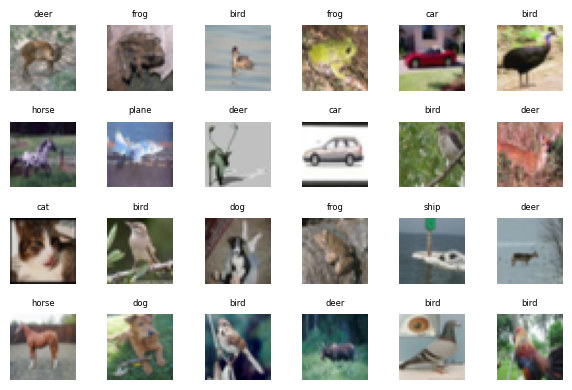

In [ ]:

# REPRESENTAMOS ALGUNAS DE LAS IMÁGENES
# =====================================

import matplotlib.pyplot as plt

fig = plt.figure(dpi=100)
c, r = 6, 4
for j in range(r):
  for i in range(c):
    ix = j*c + i
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.imshow(img)
    ax.set_title(ds['train'].classes[labels[ix].item()], fontsize=6)
    ax.axis('off')
plt.tight_layout()
plt.show()    



# **PROCEDEMOS AL ENTRENAMIENTO DEL MODELO**

In [ ]:

from tqdm import tqdm
import torch.nn.functional as F

def step(model, batch, device):
  x, y = batch
  x, y = x.to(device), y.to(device)
  y_hat = model(x)
  loss = F.cross_entropy(y_hat, y)
  acc  = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
  return loss, acc

def train(model, dl, optimizer, epochs=10, device='cuda', use_amp=True, overfit=True):
  model.to(device)
  hist = {
      'loss': [],
      'acc' : [],
      'test_loss':[],
      'test_acc' :[]
  }  
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
  for e in range(1, epochs+1):
    model.train()  # <------------------------------------ MODO ENTRENAMIENTO
    l, a = [], []
    bar = tqdm(dl['train'])
    for batch in bar:
      optimizer.zero_grad()
      with torch.cuda.amp.autocast(enabled=use_amp):
        loss, acc = step(model, batch, device)
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      # Guardamos los resultados
      l.append(loss.item()) 
      a.append(acc)
      if overfit:
        break
      bar.set_description(f'training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}')
    hist['loss'].append(np.mean(l))
    hist['acc'].append(np.mean(a))

    model.eval()   # <------------------------------------ MODO EVALUACION   
    l, a = [], []
    if overfit:
      bar = tqdm(dl['train'])
    else:
      bar = tqdm(dl['test'])
    with torch.inference_mode():
      for batch in bar:
        loss, acc = step(model, batch, device)
        l.append(loss.item())
        a.append(acc)
        if overfit:
          break
        bar.set_description(f'testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}')
    hist['test_loss'].append(np.mean(l))
    hist['test_acc'].append(np.mean(a))
    if not overfit:
      log = f'Epoch {e}/{epochs}'
      for k, v in hist.items():
        log += f' {v[-1]:.4f}'
      print(log)
  return hist          


In [ ]:

# PREPARAMOS EL PROCEDIMIENTO DE DIBUJO

import pandas as pd

def plot_hist(hist):
  fig = plt.figure(figsize=(10, 3), dpi=100)
  df = pd.DataFrame(hist)
  ax = plt.subplot(1, 2, 1)
  df[['loss','test_loss']].plot(ax=ax)
  ax.grid(True)
  ax = plt.subplot(1, 2, 2)
  df[['acc','test_acc']].plot(ax=ax)
  ax.grid(True)
  plt.show()


In [ ]:

model = PerceiverIO(num_classes=10, max_freq=5, num_freq_bands=3, num_latents=32, latent_dim=32, input_dim=3, num_blocks=3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=512, shuffle=True, num_workers=0),
    'test' : torch.utils.data.DataLoader(ds['test'], batch_size=512, shuffle=True, num_workers=0)
}


In [ ]:

# PROCEDEMOS AL ENTRENAMIENTO DE LA RED PerceiverIO
# =================================================

# CON: epochs = 10 , GPU = True    --------> Duración: 30 minutos

hist = train(model, dl, optimizer, epochs=10, overfit=False)



testing... loss 1.9725 acc 0.2532: 100%|██████████| 157/157 [00:04<00:00, 34.75it/s]


Epoch 1/10 2.0394 0.2181 1.9725 0.2532


testing... loss 1.7719 acc 0.3398: 100%|██████████| 157/157 [00:05<00:00, 30.49it/s]


Epoch 2/10 1.8934 0.2944 1.7719 0.3398


testing... loss 1.7335 acc 0.3601: 100%|██████████| 157/157 [00:05<00:00, 27.81it/s]


Epoch 3/10 1.7694 0.3393 1.7335 0.3601


testing... loss 1.6416 acc 0.3974: 100%|██████████| 157/157 [00:04<00:00, 35.26it/s]


Epoch 4/10 1.6965 0.3743 1.6416 0.3974


testing... loss 1.5962 acc 0.4321: 100%|██████████| 157/157 [00:04<00:00, 34.88it/s]


Epoch 5/10 1.6294 0.4023 1.5962 0.4321


testing... loss 1.5547 acc 0.4339: 100%|██████████| 157/157 [00:04<00:00, 35.03it/s]


Epoch 6/10 1.5607 0.4324 1.5547 0.4339


testing... loss 1.4877 acc 0.4631: 100%|██████████| 157/157 [00:04<00:00, 34.93it/s]


Epoch 7/10 1.5153 0.4529 1.4877 0.4631


testing... loss 1.4225 acc 0.4889: 100%|██████████| 157/157 [00:04<00:00, 34.86it/s]


Epoch 8/10 1.4689 0.4687 1.4225 0.4889


testing... loss 1.3993 acc 0.4970: 100%|██████████| 157/157 [00:04<00:00, 34.96it/s]


Epoch 9/10 1.4367 0.4797 1.3993 0.4970


testing... loss 1.4207 acc 0.4933: 100%|██████████| 157/157 [00:04<00:00, 34.96it/s]

Epoch 10/10 1.4065 0.4903 1.4207 0.4933


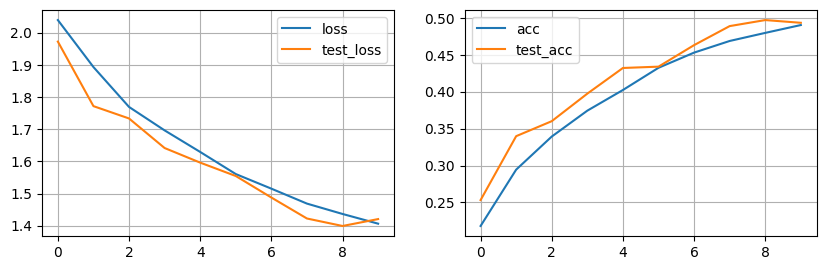

In [ ]:

# REPRESENTAMOS LAS GRÁFICAS DE ENTRENAMIENTO
# ===========================================

# He utilizado 10 epochs en lugar de los 100 que ponía en el NOTEBOOK
# A diferencia de los tiempos por epoch (que parece que a él le salen de 10 segundos)
# que venían, aquí salen de más de 2 minutos (utilizando GPU)

plot_hist(hist)


In [ ]:

imgs, labels = next(iter(dl['train']))

model.eval()

with torch.inference_mode():
  logits = model(imgs.cuda())
  predicciones = torch.argmax(logits, axis=1).cpu()

predicciones.shape  


torch.Size([64])

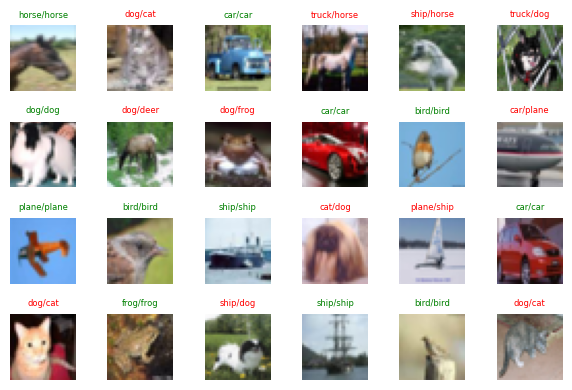

In [ ]:

fig = plt.figure(dpi=100)
c, r = 6, 4
for j in range(r):
  for i in range(c):
    ix = j*c + i
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.imshow(img)
    gt = ds['test'].classes[labels[ix].item()]
    pr = ds['test'].classes[predicciones[ix].item()]
    ax.set_title(f'{pr}/{gt}', fontsize=6, color='green' if pr == gt else 'red')
    ax.axis('off')
plt.tight_layout()
plt.show()    
